# Visualização de Sinais no Domínio do Tempo

Este notebook extrai as funções de visualização dos scripts `visualize_fft_signals.py` e `visualize_impulse_signals.py`, focando apenas nos plots do domínio do tempo conforme solicitado.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Adicionar o diretório atual ao path para garantir importação dos módulos locais
sys.path.append(os.path.abspath('src'))

# Importações dos módulos do projeto
import segment_and_split_data as ssd
import generate_synthetic_data as gsd
import bearing_utils as bu
from generate_impulse_data import gerar_dados_sinteticos_treino, params_drive_end, amplitudes_referencia

Iniciando a leitura e segmentação dos arquivos em 'c:\Users\Cliente\Documents\GitHub\TCC\data'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 3184

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE (chave: '1730

## 1. Visualização Método FFT (Senoide Combinada)

In [8]:
def visualize_fft_time_domain(selected_rpm=1730):
    print("--- Preparando Visualização do Sinal FFT (Domínio do Tempo) ---")
    
    # 1. Configuração
    fs = 12000
    
    # 2. Obter um segmento normal base
    base_segment = None
    for key, df in ssd.dicionario_treino.items():
        if df['rotacao_rpm'].iloc[0] == selected_rpm:
            base_segment = df['amplitude'].values
            break
            
    if base_segment is None:
        if len(ssd.dicionario_treino) > 0:
            key = list(ssd.dicionario_treino.keys())[0]
            base_segment = ssd.dicionario_treino[key]['amplitude'].values
            selected_rpm = ssd.dicionario_treino[key]['rotacao_rpm'].iloc[0]
            print(f"Aviso: RPM exato não encontrado, usando {selected_rpm} de {key}")
        else:
            print("Erro: Sem segmentos normais disponíveis.")
            return

    # 3. Definir Falhas
    fault_types = ['Normal', 'inner', 'outer', 'ball']
    
    # Parâmetros de Visualização
    diam = 0.5 
    k_vals = {'inner': 1, 'outer': 0.1, 'ball': 0.1}
    
    # Setup Plot - Apenas 1 coluna (Tempo)
    rows = len(fault_types)
    cols = 1
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), constrained_layout=True)
    
    segment_duration = len(base_segment) / fs
    
    for i, f_type in enumerate(fault_types):
        
        # Inicializar sinais
        signal_pure = np.zeros_like(base_segment)
        signal_final = base_segment.copy()
        
        if f_type != 'Normal':
            # Gerar Componente Sintético
            k_val = k_vals.get(f_type, 0.1)
            
            spec_df = pd.DataFrame()
            if f_type == 'inner':
                spec_df = bu.calcular_espectro_inner_completo(diam, selected_rpm, K=k_val)
            elif f_type == 'outer':
                spec_df = bu.calcular_espectro_outer_race(diam, selected_rpm, K=k_val, max_harmonics=10)
            elif f_type == 'ball':
                spec_df = bu.calcular_espectro_ball_completo(diam, selected_rpm, K=k_val)
                
            # Sintetizar Sinal no Tempo
            syn_sig = gsd.synthesize_time_signal(spec_df, duration=segment_duration, fs=fs)
            
            # Alinhar tamanhos
            if len(syn_sig) > len(base_segment):
                syn_sig = syn_sig[:len(base_segment)]
            elif len(syn_sig) < len(base_segment):
                syn_sig = np.pad(syn_sig, (0, len(base_segment) - len(syn_sig)))
                
            signal_pure = syn_sig
            signal_final = base_segment + syn_sig
        
        # --- Plot Domínio do Tempo ---
        # Se cols=1, axes[i] é o eixo direto
        ax_t = axes[i]
        
        # Vetor de tempo
        n = len(signal_final)
        t = np.linspace(0, n/fs, n)
        
        # Plot Combinado/Original
        label_final = "Original Normal" if f_type == 'Normal' else "Sinal Combinado (Normal + Sintético)"
        ax_t.plot(t, signal_final, color='#2c3e50', alpha=0.6, linewidth=0.8, label=label_final)
        
        # Plot Sintético Puro (se não for normal)
        if f_type != 'Normal':
            ax_t.plot(t, signal_pure, color='#e74c3c', alpha=0.8, linewidth=0.8, label='Sintético Puro')
            
        ax_t.set_title(f"{f_type.capitalize()} - Domínio do Tempo (Método FFT) - RPM {selected_rpm}", fontsize=14)
        ax_t.set_xlabel("Tempo (s)")
        ax_t.set_ylabel("Amplitude")
        ax_t.legend(loc='upper right', fontsize=10)
        ax_t.set_xlim(0, 0.1) # Zoom
        ax_t.grid(True, alpha=0.3)
    
    plt.show()

--- Preparando Visualização do Sinal FFT (Domínio do Tempo) ---


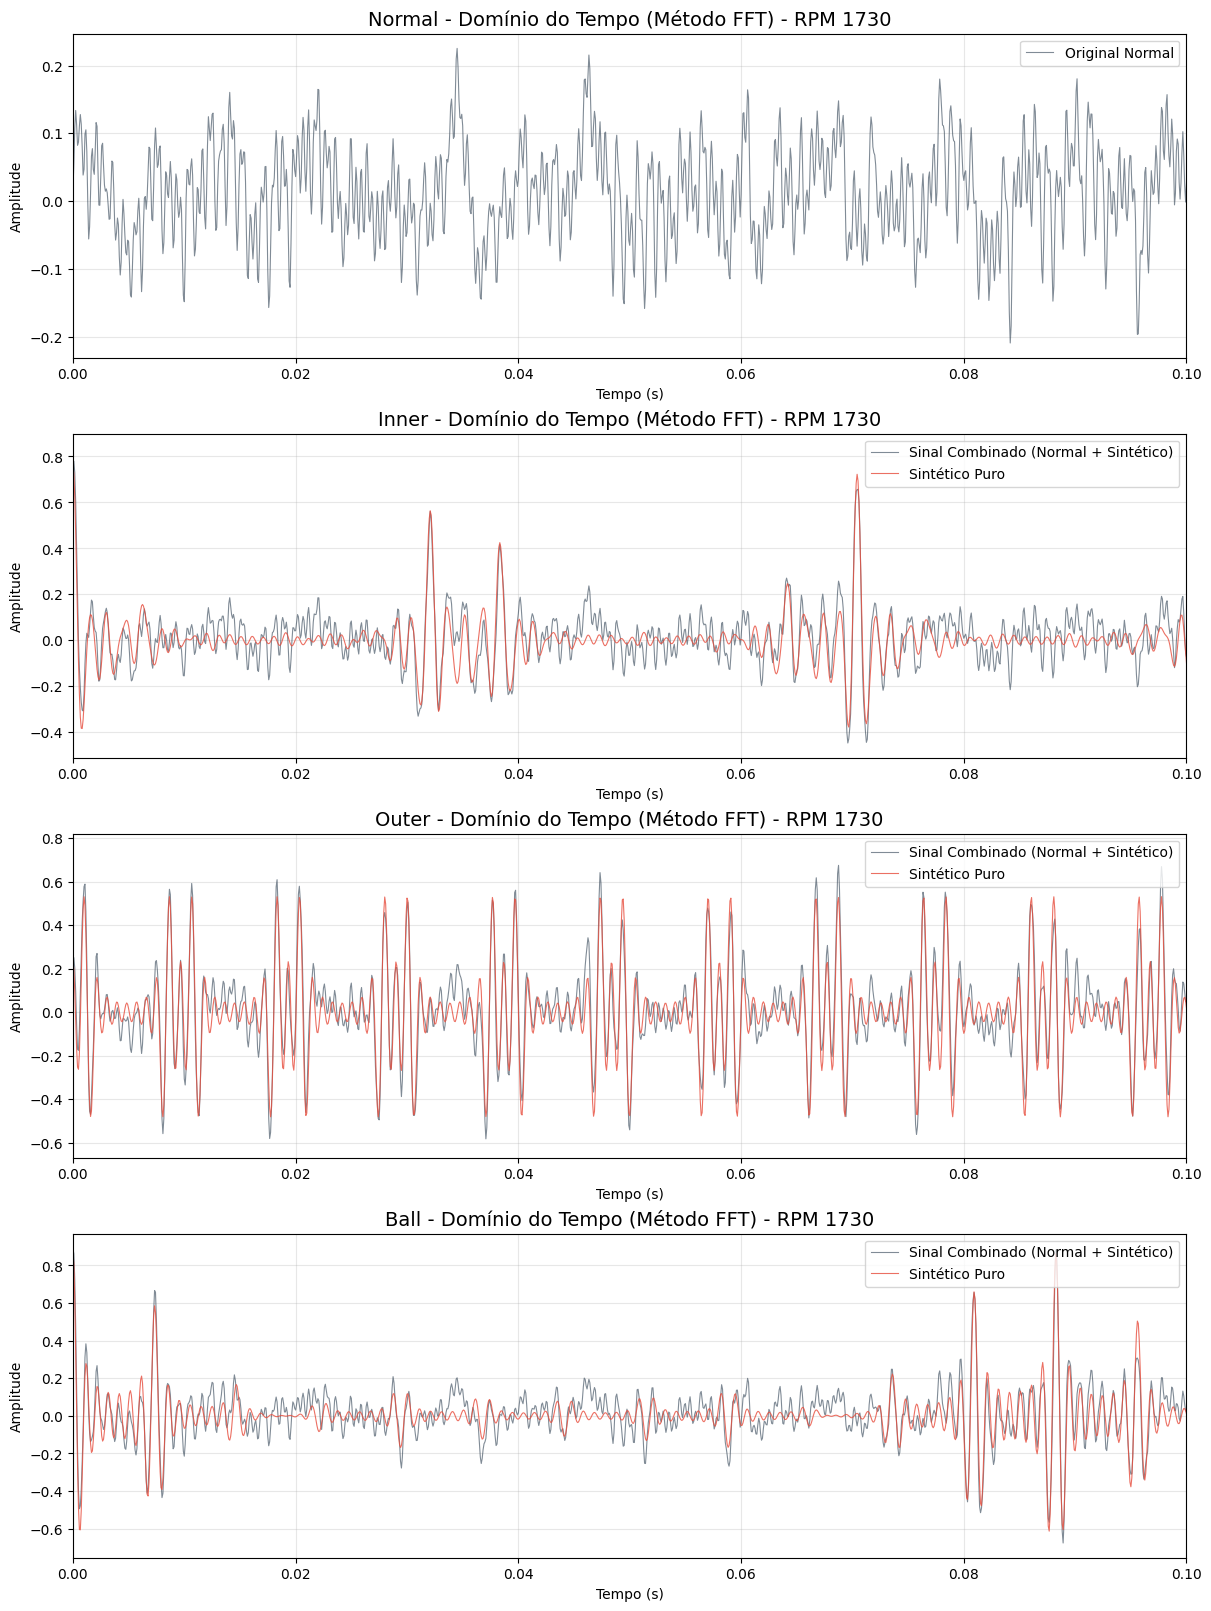

In [9]:
# Executar Visualização FFT
visualize_fft_time_domain(selected_rpm=1730)

## 2. Visualização Método Impulso

In [10]:
def visualize_impulse_time_domain(selected_rpm=1730):
    print("--- Preparando Visualização do Sinal Impulso (Domínio do Tempo) ---")
    
    # 1. Selecionar um subset com o RPM especificado
    dicionario_subset = {}
    for k, df in ssd.dicionario_treino.items():
        if df['rotacao_rpm'].iloc[0] == selected_rpm:
            dicionario_subset[k] = df
            break
    
    if not dicionario_subset:
        keys_subset = list(ssd.dicionario_treino.keys())[:1]
        dicionario_subset = {k: ssd.dicionario_treino[k] for k in keys_subset}
        selected_rpm = dicionario_subset[list(dicionario_subset.keys())[0]]['rotacao_rpm'].iloc[0]
        print(f"Aviso: RPM exato não encontrado, usando {selected_rpm}")
    
    # 2. Gerar dados sintéticos
    print("Gerando sinais sintéticos (Impulso)...")
    df_viz = gerar_dados_sinteticos_treino(
        dicionario_treino=dicionario_subset,
        TAXA_AMOSTRAL=12000,
        params_drive_end=params_drive_end,
        amplitudes_referencia=amplitudes_referencia,
        multiplicadores=[1], 
        fases_para_adicionar_rad=[0],
        damping_ratio=0.1,
        duracao_pulso_seg=0.1,
        profundidade_modulacao=0.5
    )

    # 3. Plotagem
    tipos_falha = ['Normal', 'Pista Externa', 'Pista Interna', 'Esfera']
    cols = 1
    rows = len(tipos_falha)
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), constrained_layout=True)
    
    fs = 12000
    
    for i, tipo in enumerate(tipos_falha):
        # Filtrar o primeiro exemplo deste tipo
        subset = df_viz[df_viz['tipo_falha_adicionada'] == tipo]
        if subset.empty:
            continue
            
        row_data = subset.iloc[0]
        sinal_final = row_data['sinal_final']
        sinal_puro = row_data['sinal_puro']
        rpm = row_data['rpm']
        
        # Vetor de tempo
        n = len(sinal_final)
        t = np.linspace(0, n/fs, n)
        
        # --- Plot Domínio do Tempo ---
        ax_t = axes[i]
        
        # Plot Combined
        ax_t.plot(t, sinal_final, color='#2c3e50', alpha=0.6, linewidth=0.8, label='Sinal Combinado')
        
        # Plot Pure Synthetic (if not Normal)
        if tipo != 'Normal':
            ax_t.plot(t, sinal_puro, color='#e74c3c', alpha=0.8, linewidth=0.8, label='Sintético Puro')
            
        ax_t.legend(loc='upper right', fontsize=10)
        
        title_color = '#e74c3c' if tipo != 'Normal' else '#27ae60'
        ax_t.set_title(f"{tipo} - Tempo (Método Impulso) - RPM {rpm:.0f}", fontsize=14, color=title_color)
            
        ax_t.set_xlabel("Tempo (s)")
        ax_t.set_ylabel("Amplitude")
        ax_t.set_xlim(0, 0.2) # Zoom 200ms
        ax_t.grid(True, alpha=0.3)
            
    plt.show()

--- Preparando Visualização do Sinal Impulso (Domínio do Tempo) ---
Gerando sinais sintéticos (Impulso)...
Usando 999 modos naturais para Outer Race (primeiro: 5037.1 Hz)
Usando 999 modos naturais para Inner Race (primeiro: 14142.8 Hz)
Gerando Sinais... (damp=0.1, dur=0.1s, mod=0.5)
Geração concluída. Total de 4 segmentos de treino.


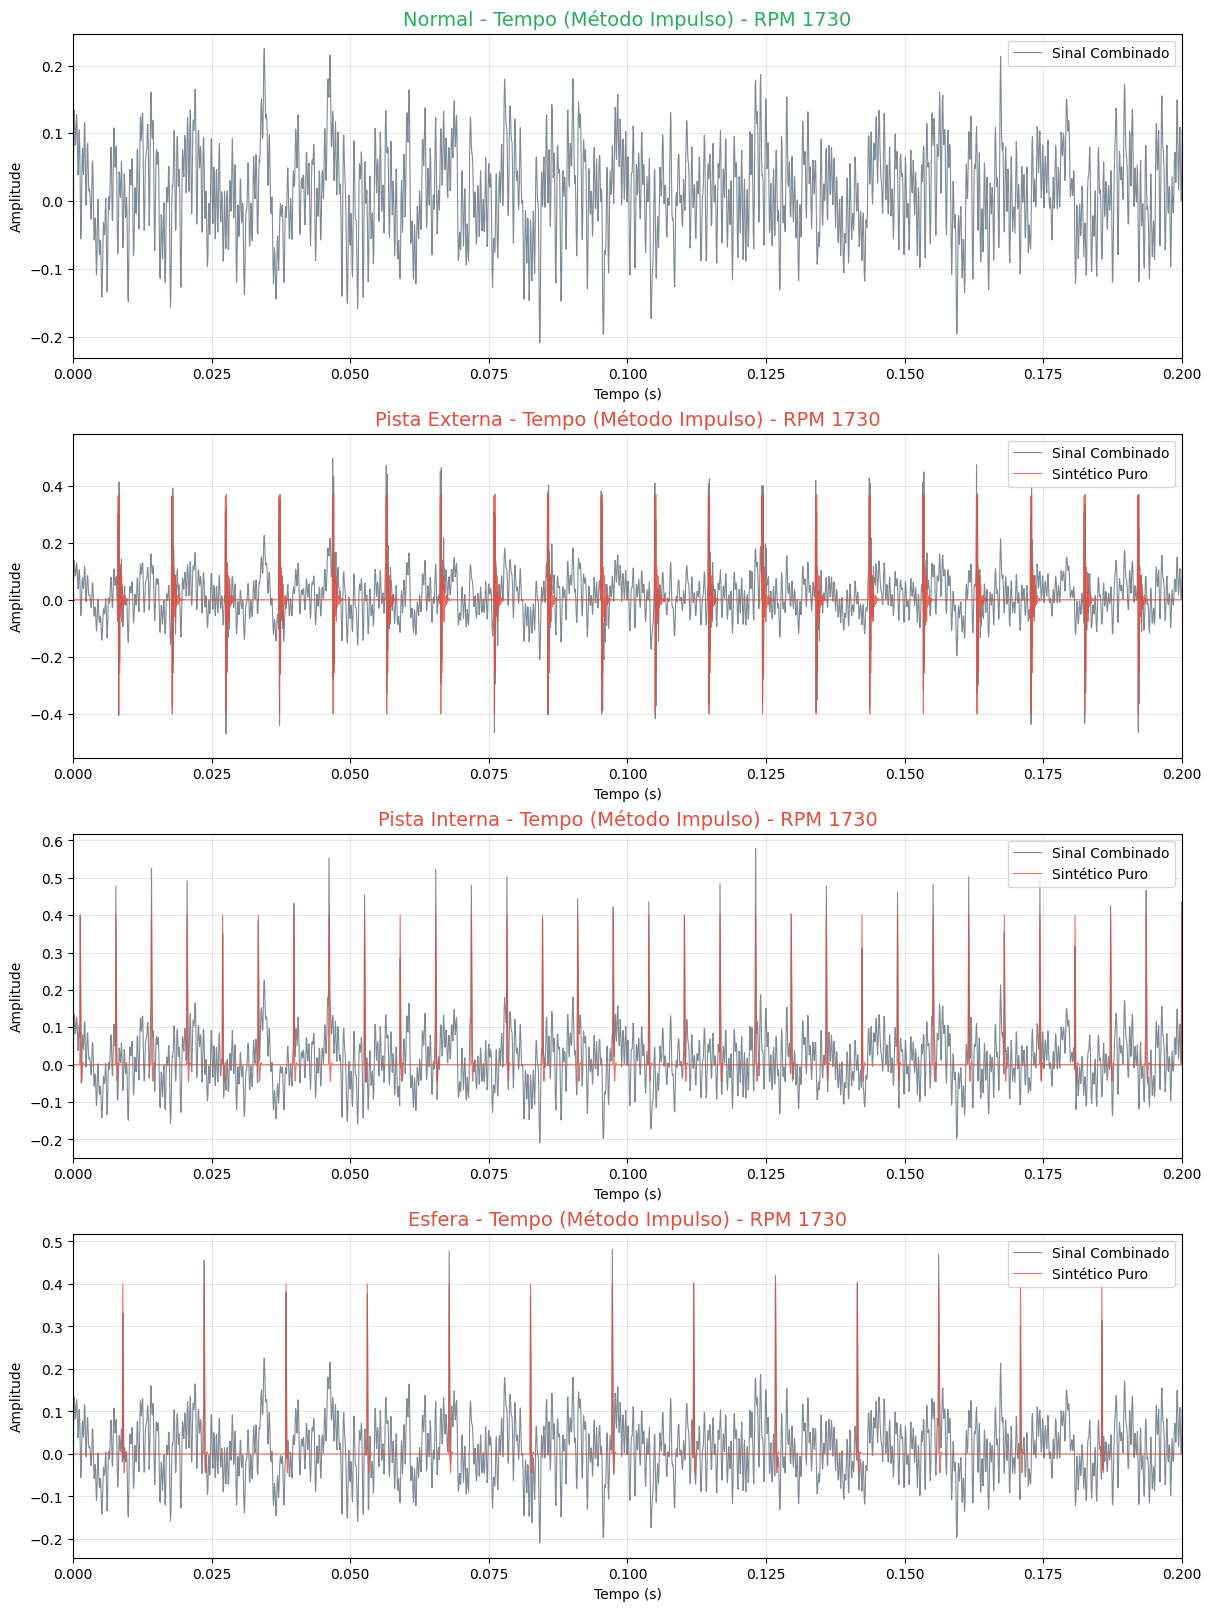

In [11]:
# Executar Visualização Impulso
visualize_impulse_time_domain(selected_rpm=1730)